# InsideAirbnb Temporal Dynamics (InsideAirbnb)

This notebook:
1. Builds a night-level panel dataset (listing × date) for each city + snapshot.
2. Performs seasonality analysis (price + booking probability).
3. Creates temporal train/validation/test splits (Jan–Sep / Oct–Nov / Dec–Feb).
4. Trains XGBoost + Neural Network models for:
   - Regression: price
   - Classification: isBooked
5. Logs Neural Network training to TensorBoard and includes screenshots + interpretation.


In [45]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, accuracy_score

from xgboost import XGBRegressor, XGBClassifier
import tensorflow as tf
from datetime import datetime

pd.set_option("display.max_columns", 200)

cities = {
    "austin": ["2024-12-14", "2025-03-06"],
    "chicago": ["2024-12-18", "2025-03-11"],
    "santa_cruz": ["2024-12-31", "2025-03-28"],
    "washington_dc": ["2024-12-18", "2025-03-13"],
}

projectRoot = Path("..").resolve()
dataRawDir = projectRoot / "data" / "raw"
dataDerivedDir = projectRoot / "data" / "derived"
panelSamplesDir = dataDerivedDir / "panelSamples"

logsDir = projectRoot / "logs"
nnPriceLogsDir = logsDir / "nnPrice"
nnBookedLogsDir = logsDir / "nnBooked"

for d in [panelSamplesDir, nnPriceLogsDir, nnBookedLogsDir]:
    d.mkdir(parents=True, exist_ok=True)

print("projectRoot:", projectRoot)
print("dataRawDir:", dataRawDir)


projectRoot: /Users/hamsikarg/Desktop/insideairbnb-temporal
dataRawDir: /Users/hamsikarg/Desktop/insideairbnb-temporal/data/raw


## Part 1: Dataset Construction (Night-level panel)

For each city + snapshot:
- Load `listings.csv` and `calendar.csv` (or `calendar.csv.gz`)
- Left merge on `listing_id`
- Create:
  - `price` numeric (canonical)
  - `isBooked` from `available`
  - datetime `date`
  - time features: month, dayOfWeek, weekOfYear, isWeekend, dayOfYear
- Save a sampled parquet (for reuse and to avoid memory crashes)


In [46]:
def loadCsvOrGz(pathNoExt: Path) -> pd.DataFrame:
    csvPath = pathNoExt.with_suffix(".csv")
    gzPath = pathNoExt.with_suffix(".csv.gz")
    if csvPath.exists():
        return pd.read_csv(csvPath)
    if gzPath.exists():
        return pd.read_csv(gzPath)
    raise FileNotFoundError(f"Missing {csvPath.name} or {gzPath.name} in {pathNoExt.parent}")

def cleanPrice(series: pd.Series) -> pd.Series:
    s = series.astype(str).str.replace(r"[\$,]", "", regex=True)
    s = s.replace("nan", np.nan)
    return s.astype(float)

def buildPanel(city: str, snapshotDate: str) -> pd.DataFrame:
    base = dataRawDir / city / snapshotDate
    listingsDf = loadCsvOrGz(base / "listings")
    calendarDf = loadCsvOrGz(base / "calendar")

    if "id" in listingsDf.columns and "listing_id" not in listingsDf.columns:
        listingsDf = listingsDf.rename(columns={"id": "listing_id"})

    calendarDf["date"] = pd.to_datetime(calendarDf["date"], errors="coerce")
    calendarDf["isBooked"] = (calendarDf["available"] == "f").astype(int)

    panelDf = calendarDf.merge(listingsDf, on="listing_id", how="left")

    if "adjusted_price" in panelDf.columns and panelDf["adjusted_price"].notna().any():
        panelDf["price"] = cleanPrice(panelDf["adjusted_price"])
    elif "price_x" in panelDf.columns:
        panelDf["price"] = cleanPrice(panelDf["price_x"])
    elif "price" in panelDf.columns:
        panelDf["price"] = cleanPrice(panelDf["price"])
    else:
        raise KeyError("No usable price column found (adjusted_price / price_x / price).")

    panelDf["month"] = panelDf["date"].dt.month
    panelDf["dayOfWeek"] = panelDf["date"].dt.dayofweek
    panelDf["weekOfYear"] = panelDf["date"].dt.isocalendar().week.astype(int)
    panelDf["isWeekend"] = panelDf["dayOfWeek"].isin([5, 6]).astype(int)
    panelDf["dayOfYear"] = panelDf["date"].dt.dayofyear
    panelDf = panelDf.dropna(subset=["price","date"])

    panelDf["city"] = city
    panelDf["snapshotDate"] = snapshotDate

    keepCols = [
        "listing_id","date","available","isBooked","price",
        "minimum_nights_x","maximum_nights_x",
        "room_type","property_type","neighbourhood_cleansed",
        "accommodates","bedrooms","beds","bathrooms",
        "number_of_reviews","review_scores_rating",
        "latitude","longitude",
        "month","dayOfWeek","weekOfYear","isWeekend","dayOfYear",
        "city","snapshotDate"
    ]
    keepCols = [c for c in keepCols if c in panelDf.columns]
    panelDf = panelDf[keepCols]

    return panelDf


## Part 2: Seasonality Analysis

For each city + snapshot, we compute:
- Avg price by month
- Avg booking probability by month
- Weekend vs weekday averages
- Avg price by month by room_type (top categories)

We run analysis on a sampled panel to keep memory stable.


In [47]:
def avgByMonth(df):
    return (df.groupby("month")
            .agg(avgPrice=("price","mean"),
                 bookProb=("isBooked","mean"))
            .reset_index()
            .sort_values("month"))

def weekendVsWeekday(df):
    return (df.groupby("isWeekend")
            .agg(avgPrice=("price","mean"),
                 bookProb=("isBooked","mean"))
            .reset_index())

def priceByMonthAndRoomType(df, topK=6):
    if "room_type" not in df.columns:
        return None
    top = df["room_type"].value_counts().head(topK).index
    sub = df[df["room_type"].isin(top)]
    return (sub.groupby(["month","room_type"])["price"]
            .mean().reset_index(name="avgPrice"))

def plotMonthlyLine(df, y, title, yLabel):
    plt.figure()
    plt.plot(df["month"], df[y], marker="o")
    plt.xticks(range(1,13))
    plt.xlabel("Month")
    plt.ylabel(yLabel)
    plt.title(title)
    plt.grid(True)
    plt.show()

def plotWeekendBars(df, y, title, yLabel):
    labels = df["isWeekend"].map({0:"Weekday", 1:"Weekend"})
    plt.figure()
    plt.bar(labels, df[y])
    plt.ylabel(yLabel)
    plt.title(title)
    plt.show()

def plotRoomTypeLines(df, title):
    plt.figure()
    for rt, grp in df.groupby("room_type"):
        plt.plot(grp["month"], grp["avgPrice"], marker="o", label=str(rt))
    plt.xticks(range(1,13))
    plt.xlabel("Month")
    plt.ylabel("Avg Price")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()



=== austin | 2024-12-14 ===


/var/folders/15/s_tyfxtj47vcj4kqv7cfs5rc0000gn/T/ipykernel_24712/2584170067.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(csvPath)


panel shape: (5475, 25)


,listing_id,date,price,available,isBooked
1603168,35937190,2024-12-14,2300.0,f,1
1603169,35937190,2024-12-15,2300.0,t,0
1603170,35937190,2024-12-16,2300.0,t,0


saved sample: /Users/hamsikarg/Desktop/insideairbnb-temporal/data/derived/panelSamples/austin_2024-12-14_sample.parquet


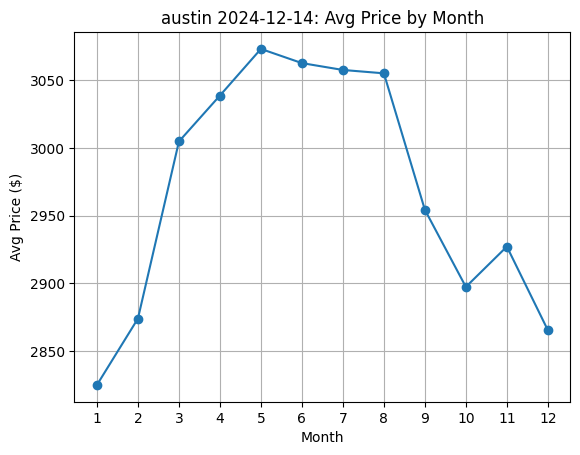

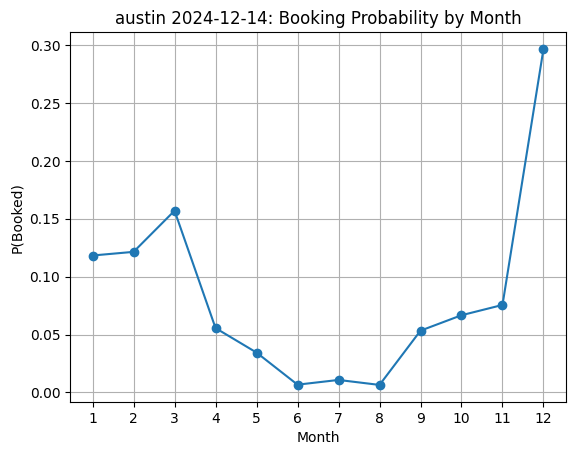

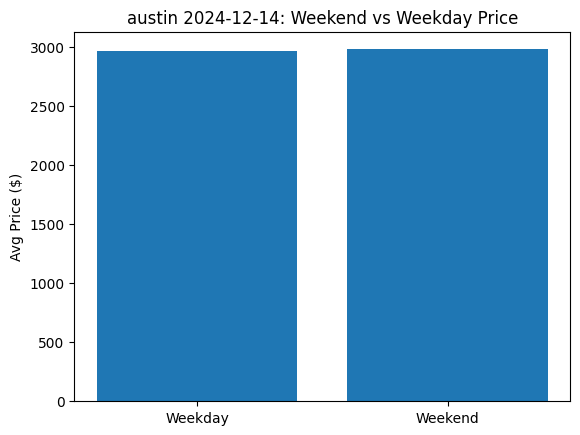

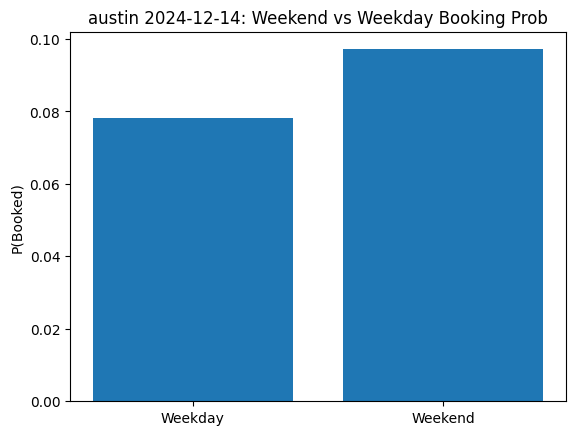

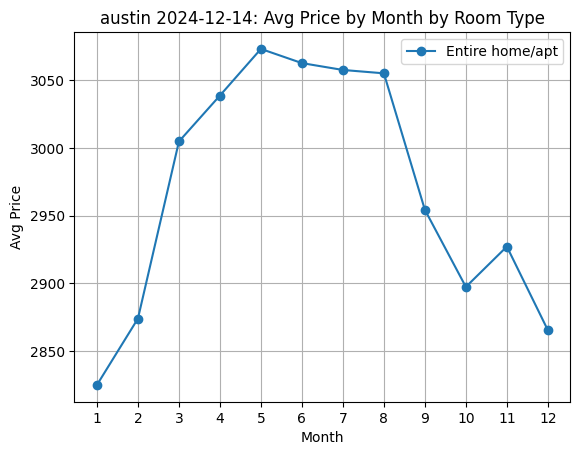


=== austin | 2025-03-06 ===


/var/folders/15/s_tyfxtj47vcj4kqv7cfs5rc0000gn/T/ipykernel_24712/2584170067.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(csvPath)


panel shape: (5119, 25)


,listing_id,date,price,available,isBooked
1537054,35937190,2025-03-12,2500.0,f,1
1537055,35937190,2025-03-13,2500.0,t,0
1537056,35937190,2025-03-14,2900.0,t,0


saved sample: /Users/hamsikarg/Desktop/insideairbnb-temporal/data/derived/panelSamples/austin_2025-03-06_sample.parquet


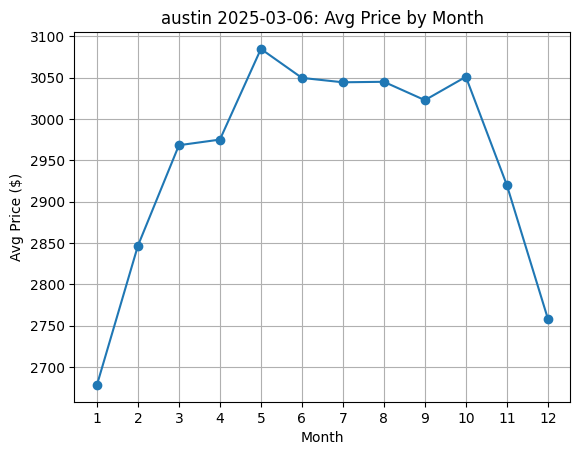

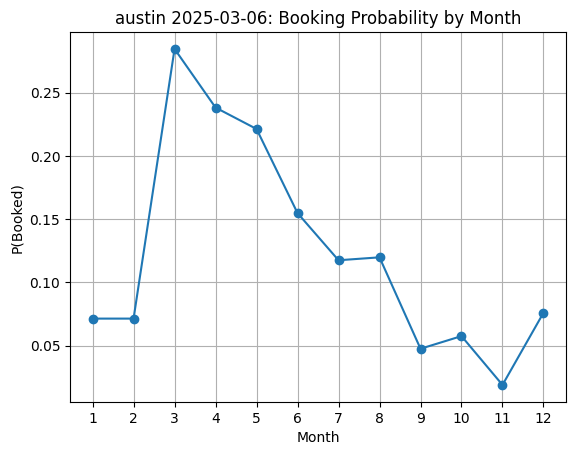

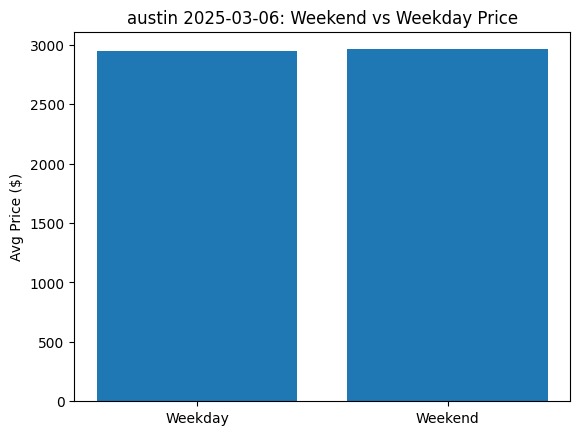

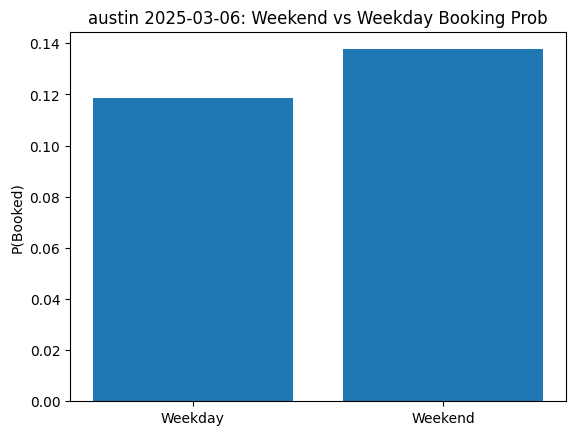

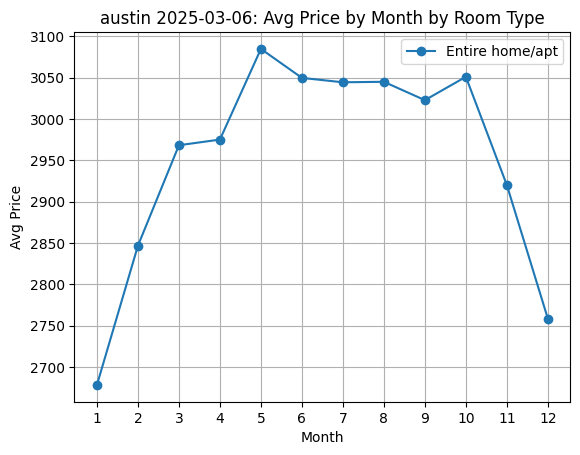


=== chicago | 2024-12-18 ===


/var/folders/15/s_tyfxtj47vcj4kqv7cfs5rc0000gn/T/ipykernel_24712/2584170067.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(csvPath)


panel shape: (730, 25)


,listing_id,date,price,available,isBooked
1533697,740616928303631888,2024-12-18,2100.0,t,0
1533698,740616928303631888,2024-12-19,2100.0,t,0
1533699,740616928303631888,2024-12-20,3000.0,f,1


saved sample: /Users/hamsikarg/Desktop/insideairbnb-temporal/data/derived/panelSamples/chicago_2024-12-18_sample.parquet


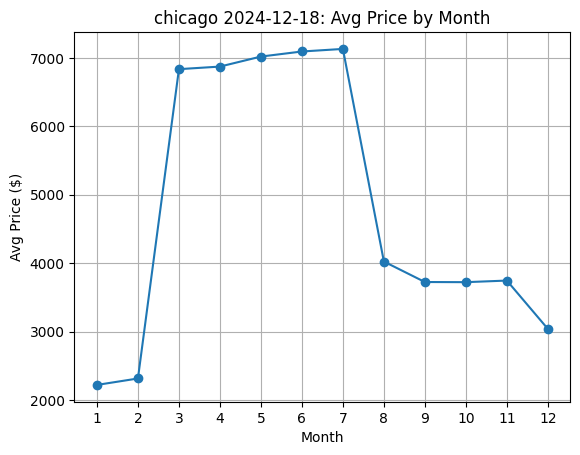

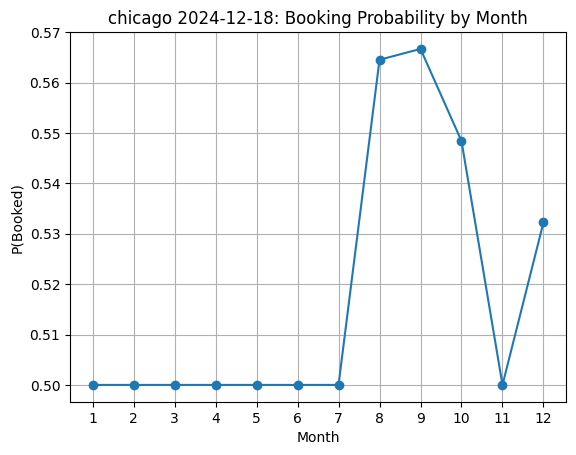

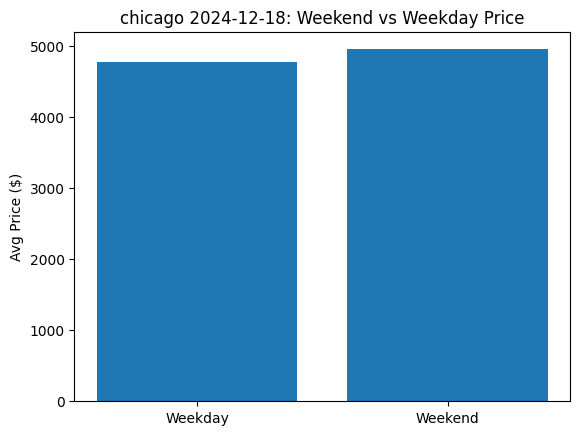

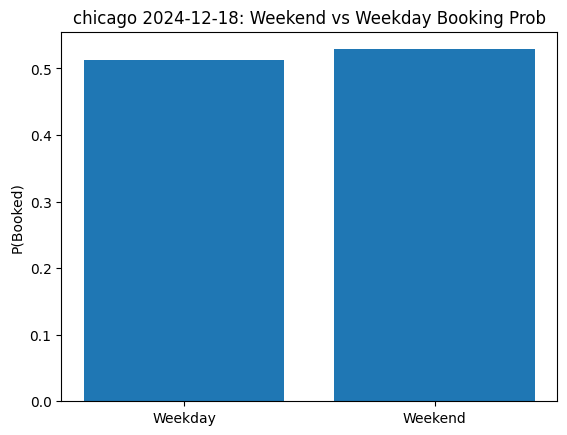

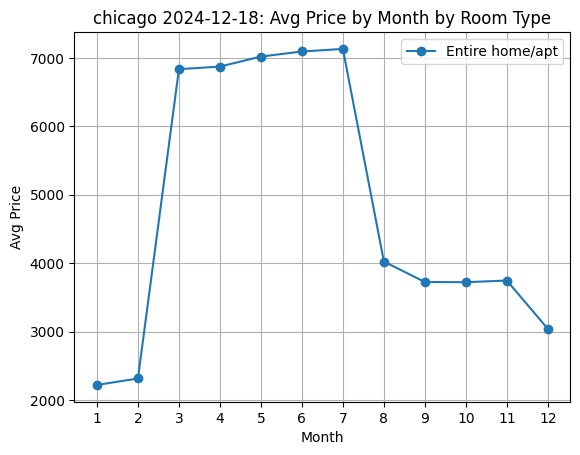


=== chicago | 2025-03-11 ===


/var/folders/15/s_tyfxtj47vcj4kqv7cfs5rc0000gn/T/ipykernel_24712/2584170067.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(csvPath)


panel shape: (730, 25)


,listing_id,date,price,available,isBooked
1471708,740616928303631888,2025-03-12,10500.0,t,0
1471709,740616928303631888,2025-03-13,10500.0,t,0
1471710,740616928303631888,2025-03-14,15000.0,t,0


saved sample: /Users/hamsikarg/Desktop/insideairbnb-temporal/data/derived/panelSamples/chicago_2025-03-11_sample.parquet


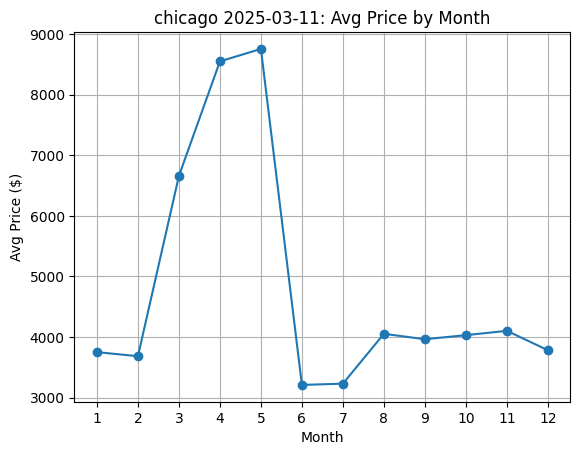

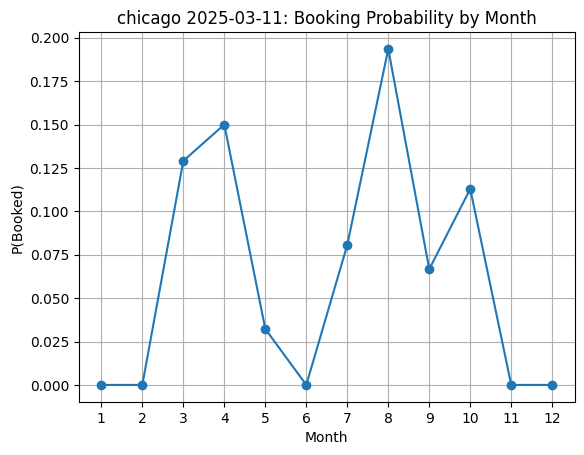

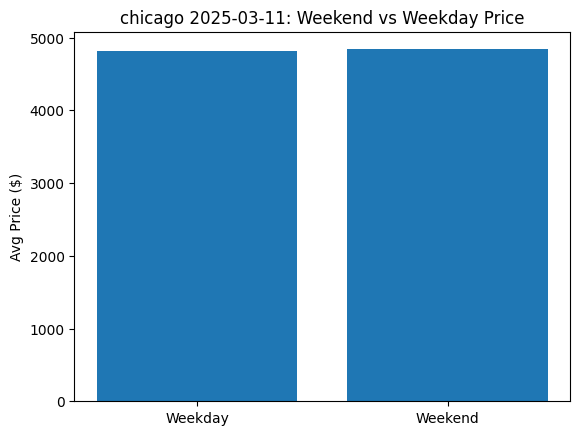

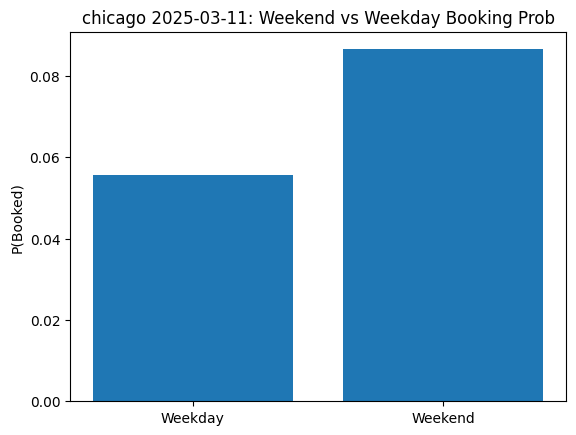

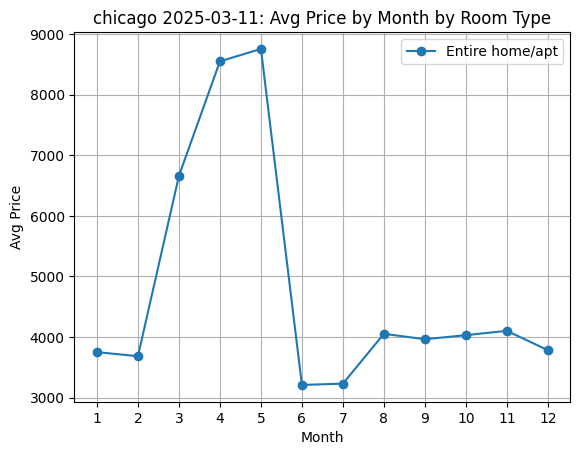


=== santa_cruz | 2024-12-31 ===
panel shape: (620390, 25)


,listing_id,date,price,available,isBooked
0,8357,2024-12-31,145.0,f,1
1,8357,2025-01-01,145.0,f,1
2,8357,2025-01-02,145.0,f,1


saved sample: /Users/hamsikarg/Desktop/insideairbnb-temporal/data/derived/panelSamples/santa_cruz_2024-12-31_sample.parquet


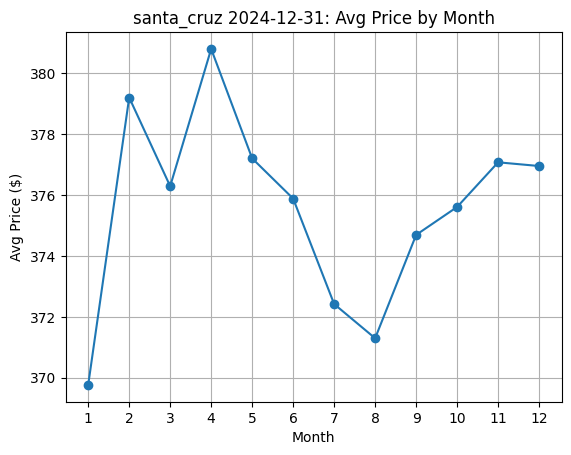

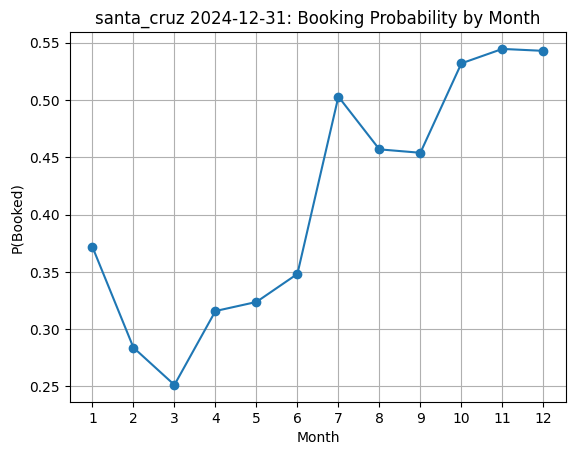

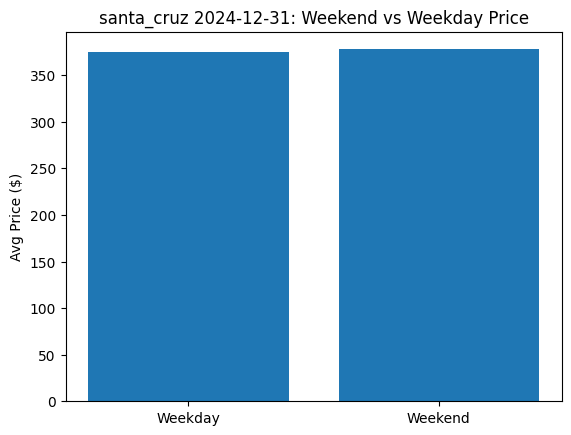

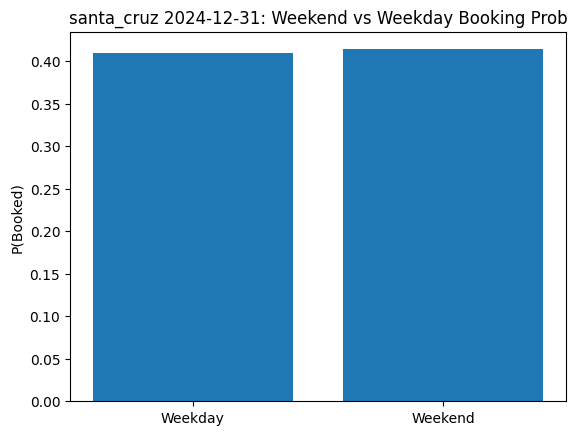

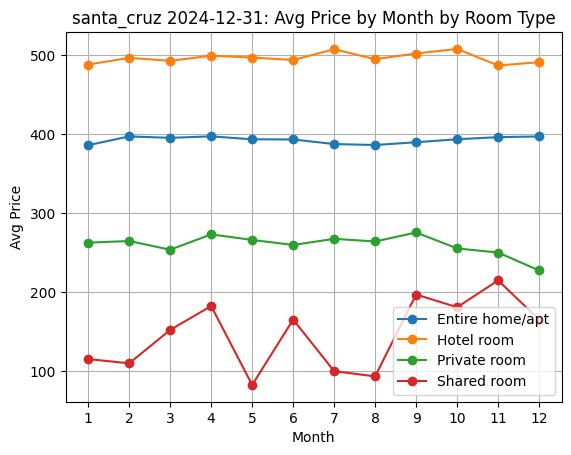


=== santa_cruz | 2025-03-28 ===
panel shape: (613431, 25)


,listing_id,date,price,available,isBooked
0,8357,2025-03-28,145.0,f,1
1,8357,2025-03-29,145.0,f,1
2,8357,2025-03-30,145.0,t,0


saved sample: /Users/hamsikarg/Desktop/insideairbnb-temporal/data/derived/panelSamples/santa_cruz_2025-03-28_sample.parquet


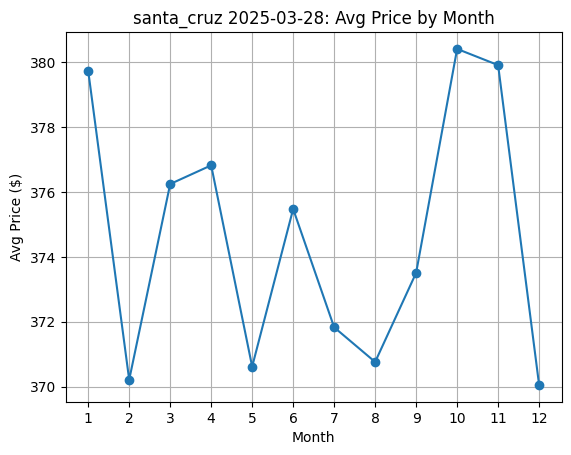

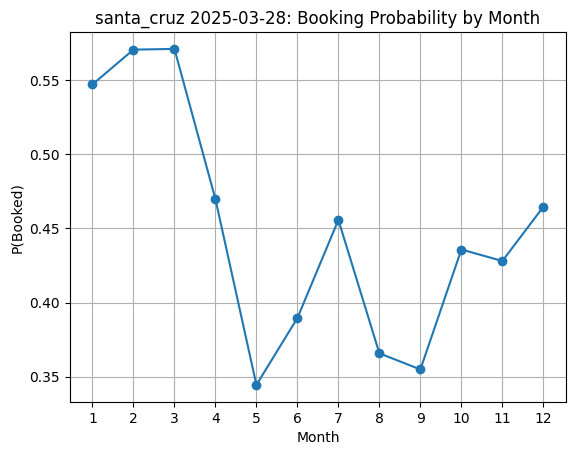

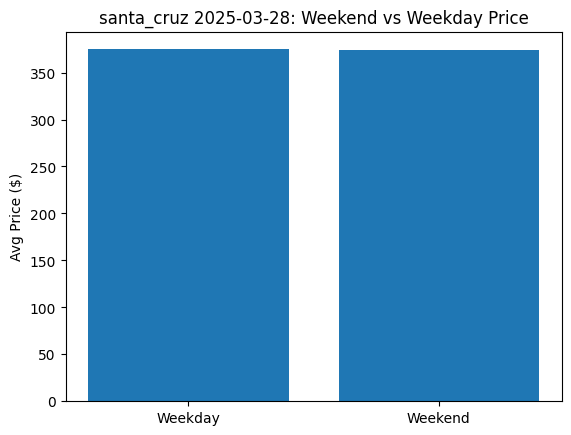

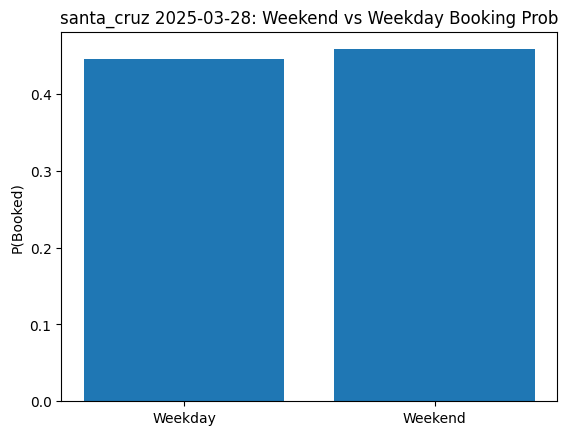

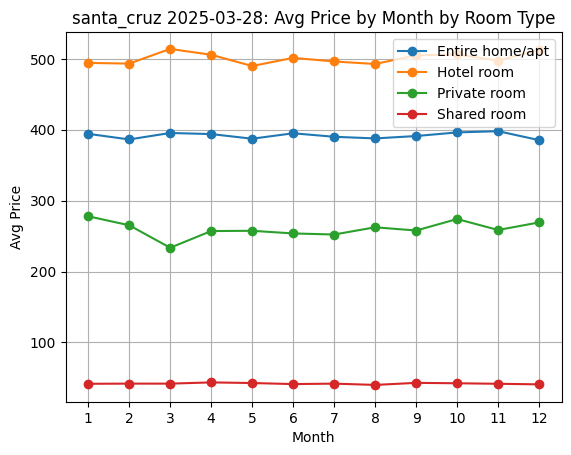


=== washington_dc | 2024-12-18 ===
panel shape: (2176398, 25)


,listing_id,date,price,available,isBooked
0,3686,2024-12-18,67.0,t,0
1,3686,2024-12-19,67.0,t,0
2,3686,2024-12-20,67.0,t,0


saved sample: /Users/hamsikarg/Desktop/insideairbnb-temporal/data/derived/panelSamples/washington_dc_2024-12-18_sample.parquet


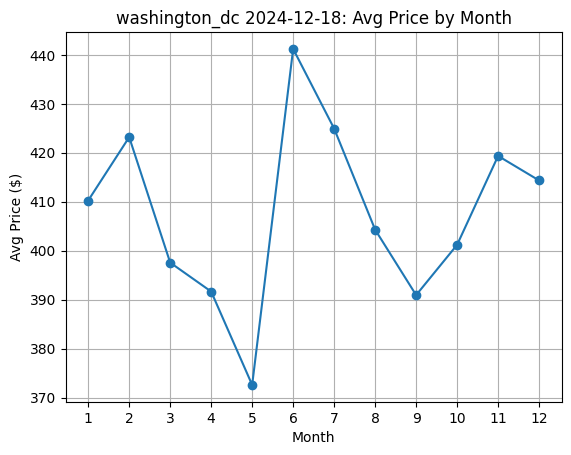

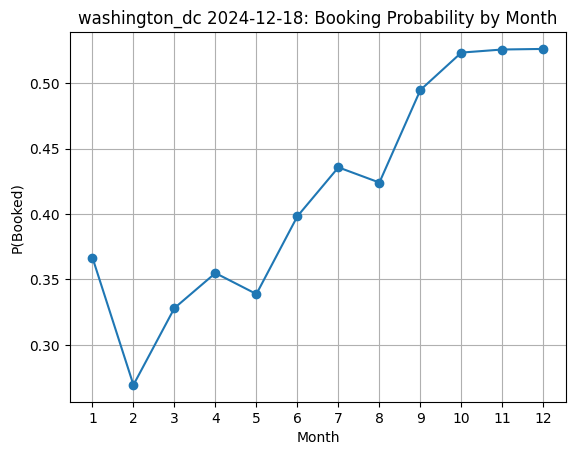

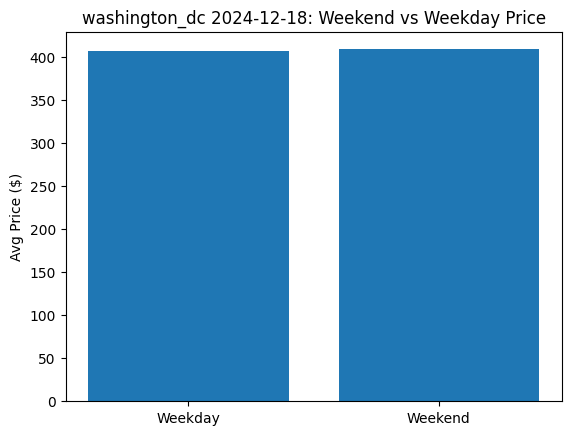

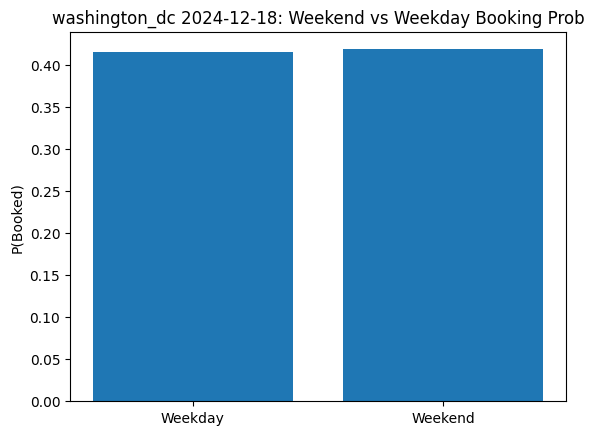

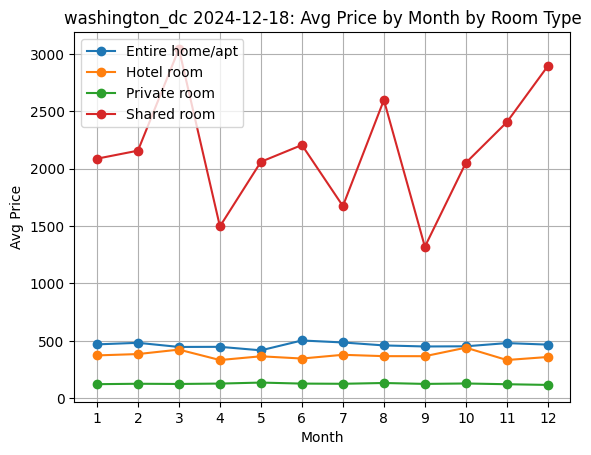


=== washington_dc | 2025-03-13 ===
panel shape: (2282941, 25)


,listing_id,date,price,available,isBooked
0,3686,2025-03-13,67.0,t,0
1,3686,2025-03-14,67.0,t,0
2,3686,2025-03-15,67.0,t,0


saved sample: /Users/hamsikarg/Desktop/insideairbnb-temporal/data/derived/panelSamples/washington_dc_2025-03-13_sample.parquet


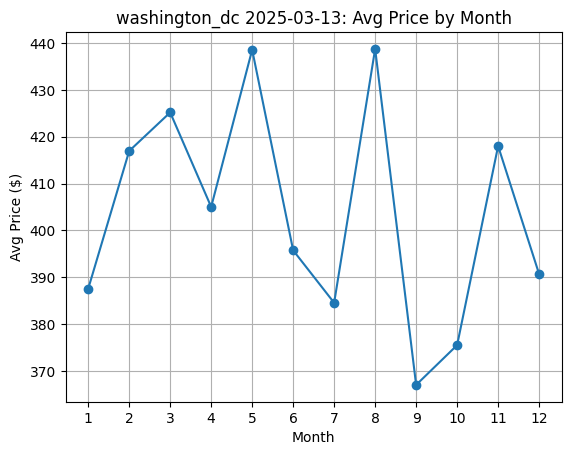

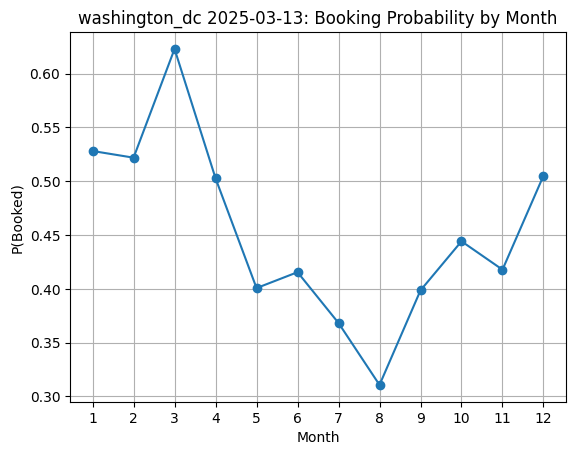

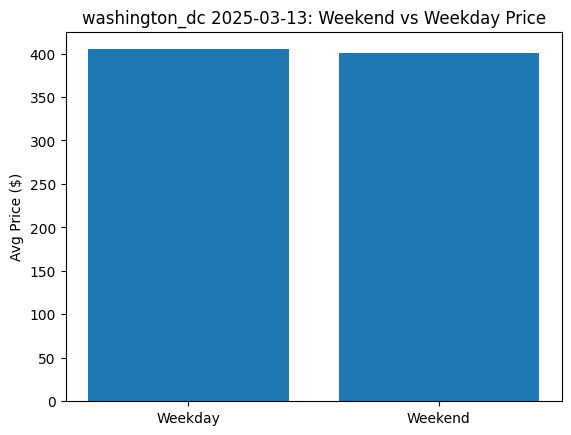

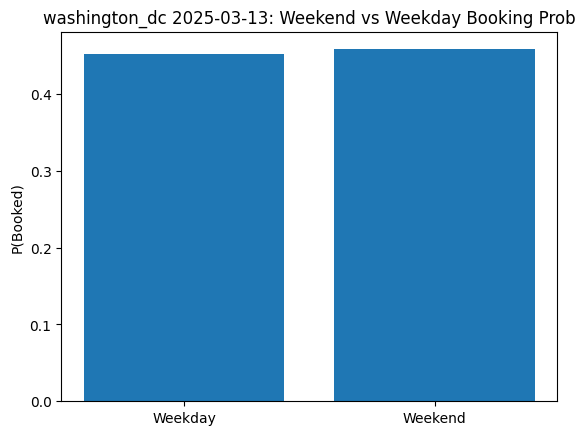

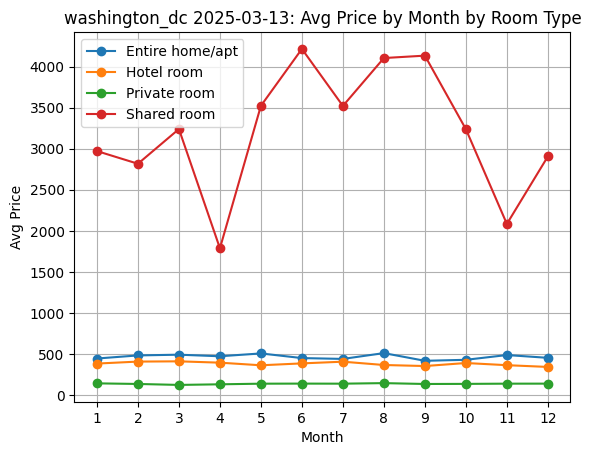

In [48]:
sampleCap = 100_000

for city, snapshots in cities.items():
    for snapshotDate in snapshots:
        print(f"\n=== {city} | {snapshotDate} ===")

        panelDf = buildPanel(city, snapshotDate)
        panelDf = panelDf.dropna(subset=["date"])

        priceDf = panelDf.dropna(subset=["price"]).copy()
        bookedDf = panelDf.dropna(subset=["available"]).copy()

        print("panel shape:", panelDf.shape)
        display(panelDf[["listing_id","date","price","available","isBooked"]].head(3))

        panelDf = panelDf.dropna(subset=["price","date"])
        sampleDf = panelDf.sample(n=min(sampleCap, len(panelDf)), random_state=42)

        samplePath = panelSamplesDir / f"{city}_{snapshotDate}_sample.parquet"
        sampleDf.to_parquet(samplePath, index=False)
        print("saved sample:", samplePath)

        byMonth = avgByMonth(sampleDf)
        wk = weekendVsWeekday(sampleDf)
        rt = priceByMonthAndRoomType(sampleDf, topK=6)

        plotMonthlyLine(byMonth, "avgPrice", f"{city} {snapshotDate}: Avg Price by Month", "Avg Price ($)")
        plotMonthlyLine(byMonth, "bookProb", f"{city} {snapshotDate}: Booking Probability by Month", "P(Booked)")

        plotWeekendBars(wk, "avgPrice", f"{city} {snapshotDate}: Weekend vs Weekday Price", "Avg Price ($)")
        plotWeekendBars(wk, "bookProb", f"{city} {snapshotDate}: Weekend vs Weekday Booking Prob", "P(Booked)")

        if rt is not None:
            plotRoomTypeLines(rt, f"{city} {snapshotDate}: Avg Price by Month by Room Type")


## Part 3: Temporal Train/Validation/Test Split

We use a month-based split to avoid temporal leakage:
- Train: Jan–Sep
- Validation: Oct–Nov
- Test: Dec–Feb


In [49]:
def temporalSplit(df):
    trainDf = df[df["month"].isin(range(1,10))].copy()
    validDf = df[df["month"].isin([10,11])].copy()
    testDf = df[df["month"].isin([12,1,2])].copy()
    return trainDf, validDf, testDf

def buildPreprocessor(numericCols, categoricalCols):
    numPipe = Pipeline([("imputer", SimpleImputer(strategy="median"))])
    catPipe = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("oneHot", OneHotEncoder(handle_unknown="ignore"))
    ])
    return ColumnTransformer([
        ("num", numPipe, numericCols),
        ("cat", catPipe, categoricalCols)
    ])

def chooseFeatureCols(df):
    candidateNumeric = [
        "accommodates","bedrooms","beds","bathrooms",
        "minimum_nights_x","maximum_nights_x",
        "number_of_reviews","review_scores_rating",
        "latitude","longitude",
        "month","dayOfWeek","weekOfYear","isWeekend","dayOfYear"
    ]
    candidateCategorical = ["room_type","property_type","neighbourhood_cleansed"]

    numericCols = [c for c in candidateNumeric if c in df.columns]
    categoricalCols = [c for c in candidateCategorical if c in df.columns]
    featureCols = numericCols + categoricalCols
    return featureCols, numericCols, categoricalCols


## Part 4: Modeling (XGBoost + Neural Network + TensorBoard)

We train:
- XGBoost regressor for price
- XGBoost classifier for booked
- Neural Network for price (MSE + MAE)
- Neural Network for booked (binary crossentropy + accuracy + AUC)


In [50]:
def trainXgbPrice(prep, xTrain, yTrain):
    model = XGBRegressor(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    pipe = Pipeline([("prep", prep), ("xgb", model)])
    pipe.fit(xTrain, yTrain)
    return pipe

def trainXgbBooked(prep, xTrain, yTrain):
    model = XGBClassifier(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42
    )
    pipe = Pipeline([("prep", prep), ("xgb", model)])
    pipe.fit(xTrain, yTrain)
    return pipe

def evalPrice(pipe, xTest, yTest):
    pred = pipe.predict(xTest)
    return {
        "rmse": float(np.sqrt(mean_squared_error(yTest, pred))),
        "mae": float(mean_absolute_error(yTest, pred))
    }

def evalBooked(pipe, xTest, yTest):
    proba = pipe.predict_proba(xTest)[:, 1]
    pred = (proba >= 0.5).astype(int)
    return {
        "auc": float(roc_auc_score(yTest, proba)),
        "accuracy": float(accuracy_score(yTest, pred))
    }

def buildNetwork(inputDim, task):
    inp = tf.keras.Input(shape=(inputDim,))
    x = tf.keras.layers.Dense(256, activation="relu")(inp)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    if task == "price":
        out = tf.keras.layers.Dense(1)(x)
        model = tf.keras.Model(inp, out)
        model.compile(optimizer="adam", loss="mse", metrics=["mae"])
        return model

    out = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inp, out)
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
    )
    return model

def trainWithTensorBoard(model, xTrain, yTrain, xValid, yValid, logRoot, epochs=15, batchSize=2048):
    runId = datetime.now().strftime("%Y%m%d-%H%M%S")
    logDir = Path(logRoot) / runId
    tb = tf.keras.callbacks.TensorBoard(log_dir=str(logDir))
    model.fit(
        xTrain, yTrain,
        validation_data=(xValid, yValid),
        epochs=epochs,
        batch_size=batchSize,
        callbacks=[tb],
        verbose=1
    )
    return logDir


In [51]:
runCity = "austin"
runSnapshotDate = "2025-03-06"

samplePath = panelSamplesDir / f"{runCity}_{runSnapshotDate}_sample.parquet"
df = pd.read_parquet(samplePath)

trainDf, validDf, testDf = temporalSplit(df)
print("train/valid/test:", trainDf.shape, validDf.shape, testDf.shape)

featureCols, numericCols, categoricalCols = chooseFeatureCols(df)
prep = buildPreprocessor(numericCols, categoricalCols)

xTrain = trainDf[featureCols]
xValid = validDf[featureCols]
xTest = testDf[featureCols]

yTrainPrice = trainDf["price"]
yValidPrice = validDf["price"]
yTestPrice = testDf["price"]

yTrainBooked = trainDf["isBooked"]
yValidBooked = validDf["isBooked"]
yTestBooked = testDf["isBooked"]

xgbPrice = trainXgbPrice(prep, xTrain, yTrainPrice)
xgbBooked = trainXgbBooked(prep, xTrain, yTrainBooked)

print("XGB price:", evalPrice(xgbPrice, xTest, yTestPrice))
print("XGB booked:", evalBooked(xgbBooked, xTest, yTestBooked))



train/valid/test: (3831, 25) (854, 25) (1260, 25)
XGB price: {'rmse': 245.4949839072324, 'mae': 100.94542468843007}
XGB booked: {'auc': 0.8954921083978559, 'accuracy': 0.9738095238095238}


In [52]:
def getFeatureNamesFromPrep(prep, numericCols, categoricalCols):
    numNames = list(numericCols)
    oneHot = prep.named_transformers_["cat"].named_steps["oneHot"]
    catNames = list(oneHot.get_feature_names_out(categoricalCols))
    return numNames + catNames

def trainXgbWithValidationPrice(prep, xTrain, yTrain, xValid, yValid):
    xTrainT = prep.fit_transform(xTrain)
    xValidT = prep.transform(xValid)

    model = XGBRegressor(
        n_estimators=3000,
        learning_rate=0.03,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42
    )

    model.fit(
        xTrainT, yTrain,
        eval_set=[(xTrainT, yTrain), (xValidT, yValid)],
        verbose=False
    )
    return prep, model

def trainXgbWithValidationBooked(prep, xTrain, yTrain, xValid, yValid):
    yTrainArr = np.asarray(yTrain).astype(int)
    neg = int((yTrainArr == 0).sum())
    pos = int((yTrainArr == 1).sum())
    scalePosWeight = neg / max(1, pos)

    xTrainT = prep.fit_transform(xTrain)
    xValidT = prep.transform(xValid)

    model = XGBClassifier(
        n_estimators=3000,
        learning_rate=0.03,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        eval_metric="auc",
        scale_pos_weight=scalePosWeight,
        random_state=42
    )

    model.fit(
        xTrainT, yTrainArr,
        eval_set=[(xTrainT, yTrainArr), (xValidT, np.asarray(yValid).astype(int))],
        verbose=False
    )
    return prep, model


In [53]:
def plotXgbCurves(model, title):
    evals = model.evals_result()
    plt.figure()
    for datasetName, metricsDict in evals.items():
        for metricName, values in metricsDict.items():
            plt.plot(values, label=f"{datasetName}:{metricName}")
    plt.xlabel("Boosting Round")
    plt.ylabel("Metric")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


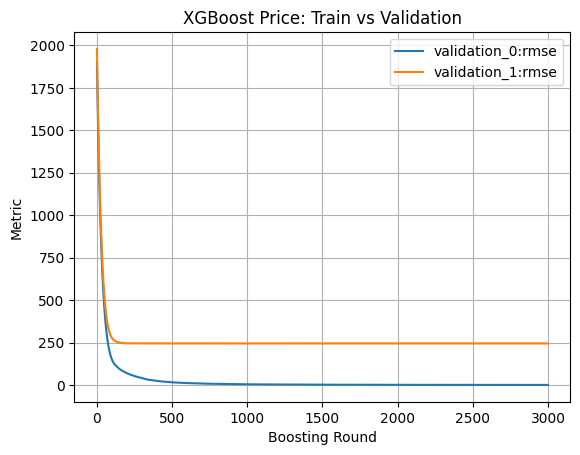

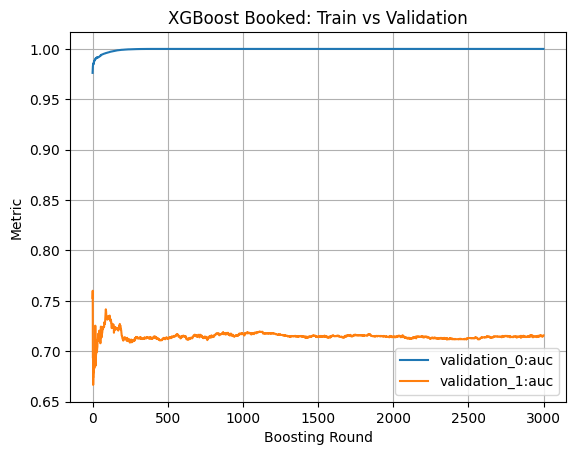

XGB monitored test | price: {'rmse': 245.10092298043995, 'mae': 98.83139793759301}
XGB monitored test | booked: {'auc': 0.8906156938653962, 'accuracy': 0.9738095238095238}


In [54]:
prepPriceMon = buildPreprocessor(numericCols, categoricalCols)
prepBookedMon = buildPreprocessor(numericCols, categoricalCols)

prepPriceMon, xgbPriceMon = trainXgbWithValidationPrice(
    prepPriceMon, xTrain, yTrainPrice.values, xValid, yValidPrice.values
)
prepBookedMon, xgbBookedMon = trainXgbWithValidationBooked(
    prepBookedMon, xTrain, yTrainBooked.values, xValid, yValidBooked.values
)

plotXgbCurves(xgbPriceMon, "XGBoost Price: Train vs Validation")
plotXgbCurves(xgbBookedMon, "XGBoost Booked: Train vs Validation")

xTestPriceT = prepPriceMon.transform(xTest)
xTestBookedT = prepBookedMon.transform(xTest)

pricePred = xgbPriceMon.predict(xTestPriceT)
bookedProba = xgbBookedMon.predict_proba(xTestBookedT)[:, 1]
bookedPred = (bookedProba >= 0.5).astype(int)

print("XGB monitored test | price:", {
    "rmse": float(np.sqrt(mean_squared_error(yTestPrice.values, pricePred))),
    "mae": float(mean_absolute_error(yTestPrice.values, pricePred))
})

print("XGB monitored test | booked:", {
    "auc": float(roc_auc_score(yTestBooked.values, bookedProba)),
    "accuracy": float(accuracy_score(yTestBooked.values, bookedPred))
})


## XGBoost Feature Importances

We extract feature importances from each model to understand which listing attributes and time features contribute most to predictions.


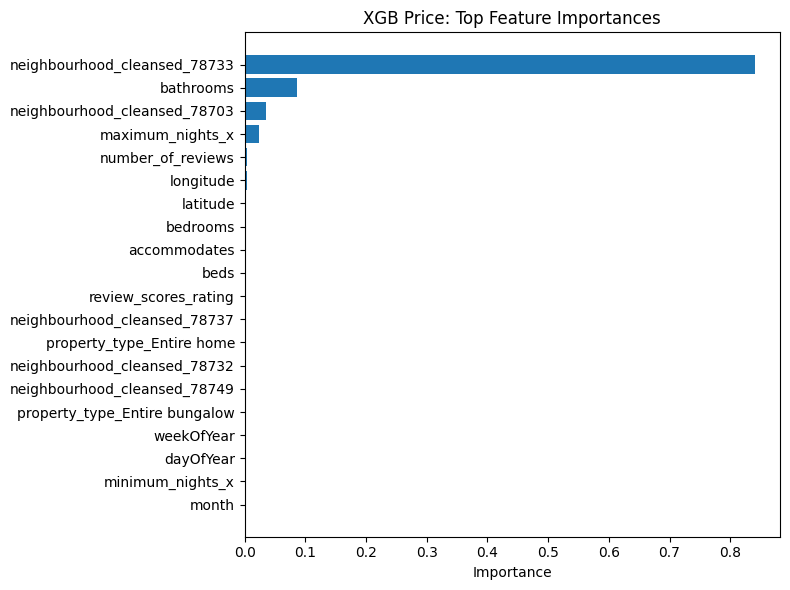

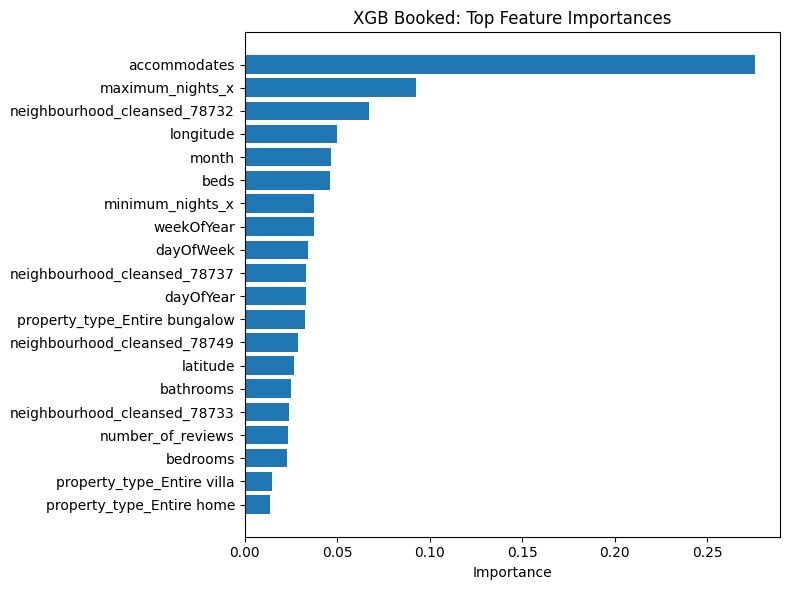

In [55]:
def plotXgbFeatureImportance(model, featureNames, title, topK=20):
    imp = model.feature_importances_
    impDf = pd.DataFrame({"feature": featureNames, "importance": imp}).sort_values("importance", ascending=False).head(topK)

    plt.figure(figsize=(8, 6))
    plt.barh(impDf["feature"][::-1], impDf["importance"][::-1])
    plt.xlabel("Importance")
    plt.title(title)
    plt.tight_layout()
    plt.show()

featureNamesPrice = getFeatureNamesFromPrep(prepPriceMon, numericCols, categoricalCols)
featureNamesBooked = getFeatureNamesFromPrep(prepBookedMon, numericCols, categoricalCols)

plotXgbFeatureImportance(xgbPriceMon, featureNamesPrice, "XGB Price: Top Feature Importances", topK=20)
plotXgbFeatureImportance(xgbBookedMon, featureNamesBooked, "XGB Booked: Top Feature Importances", topK=20)


In [56]:
prepNn = buildPreprocessor(numericCols, categoricalCols)
xTrainNn = prepNn.fit_transform(xTrain)
xValidNn = prepNn.transform(xValid)
xTestNn = prepNn.transform(xTest)

xTrainNn = xTrainNn.toarray().astype("float32") if hasattr(xTrainNn, "toarray") else xTrainNn.astype("float32")
xValidNn = xValidNn.toarray().astype("float32") if hasattr(xValidNn, "toarray") else xValidNn.astype("float32")
xTestNn = xTestNn.toarray().astype("float32") if hasattr(xTestNn, "toarray") else xTestNn.astype("float32")

nnPrice = buildNetwork(xTrainNn.shape[1], "price")
priceLogDir = trainWithTensorBoard(nnPrice, xTrainNn, yTrainPrice.values, xValidNn, yValidPrice.values, nnPriceLogsDir)
print("NN price test:", nnPrice.evaluate(xTestNn, yTestPrice.values, verbose=0), "logDir:", priceLogDir)

nnBooked = buildNetwork(xTrainNn.shape[1], "booked")
bookedLogDir = trainWithTensorBoard(nnBooked, xTrainNn, yTrainBooked.values, xValidNn, yValidBooked.values, nnBookedLogsDir)
print("NN booked test:", nnBooked.evaluate(xTestNn, yTestBooked.values, verbose=0), "logDir:", bookedLogDir)


Epoch 1/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 12489185.0000 - mae: 2942.9006 - val_loss: 12153231.0000 - val_mae: 2839.5732
Epoch 2/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 11780411.0000 - mae: 2829.8247 - val_loss: 11405227.0000 - val_mae: 2714.4922
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 10813969.0000 - mae: 2687.2190 - val_loss: 10669458.0000 - val_mae: 2585.0200
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 10307490.0000 - mae: 2584.3362 - val_loss: 9917619.0000 - val_mae: 2445.2378
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9652910.0000 - mae: 2464.7878 - val_loss: 9163042.0000 - val_mae: 2296.0312
Epoch 6/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 9012970.0000 - mae: 2329.4556 - val_loss: 8409011.0000 - val_mae: 2135.4321
Epoch 7/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8415587.0000 - mae: 2198.6169 - val_loss: 7675513.0000 - val_mae: 1965.1484
Epoch 8/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 76568

## TensorBoard

Run TensorBoard below, take screenshots of scalar plots (loss + metrics) for both models, and paste them into Markdown cells.


In [57]:
%load_ext tensorboard
%tensorboard --logdir ../logs


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 24917), started 0:49:37 ago. (Use '!kill 24917' to kill it.)

#### Data Summary. 

The project is based on Airbnb listing and calendar data for four cities—Austin, Chicago, Santa Cruz, and Washington, DC—each with two temporal snapshots per city. The compiled night-level panel dataset aggregates daily availability and booking status with static listing attributes including location, room type, capacity, and review statistics. Once price fields had been cleaned and temporal features (month, day of week, week of year, weekend indicator) had been engineered, each city–snapshot pair was subsampled to allow computational feasibility and to maintain seasonal behavior. A final modeling set was temporally divided (training, validation and test set) over calendar months so that models tested would be compared against subsequent periods rather than random data.

---

#### Seasonality Insights.

#### Price. 

Over the cities and snapshots, mean prices clearly have seasonality to them with higher prices in travel months and lower prices in off-season. The price data for weekend vs weekday prices are statistically significant, further supporting expected demand-based pricing behavior. Price seasonality curves are rather smooth, which illustrates that listing characteristics and location are more important to price formation than short-term temporal effects.

#### Booking Probability. 

Booking probability exhibits stronger seasonality than price, and there are significant spikes in the weeks and weekends affecting bookings. This suggests that while hosts gradually raise prices, demand signals around holidays and weekends affect the way consumers book more strongly.

---

#### Comparative Model Behavior.

#### XGBoost Models. 

XGBoost regressor performed well for price predictions with test RMSE of ∼245 and MAE of ∼99. Considering the breadth of price ranges in Airbnb listings, this magnitude of errors is acceptable, and means good learning of nonlinear relationships. 

The XGBoost booking classifier worked very well indeed, with test AUC = approximately **0.89** and **accuracy = 97.4%**, which illustrates an excellent separation between booked and available listings. 

The convergence of training against validation curves is significant. For the price model the training error falls sharply as validation error becomes better stable, suggesting mild overfitting but good generalization. And for the booking model validation AUC stabilizes very early and does not change, indicating a good learning mechanism with little to no overfitting.

Feature importance evaluation:  
- Price prediction is dominated by location-based attributes (neighbourhood, latitude, longitude).  
- Capacity and stay constraints (accommodates, minimum/maximum nights) have the greatest significance in the likelihood of booking.  
- Temporal (month, week of year) features add but are not important.

---

#### Analysis of Neural Network Models and TensorBoard. 

Two feedforward neural networks were trained: one for price regression (MSE loss) and one for booking classification (binary cross-entropy loss). Performance of training and validation was monitored and verified by TensorBoard. 

TensorBoard curves are perfectly converging, but validation loss plateaus early, which could be due to insufficient learning capacity compared to XGBoost. In sparse tabular data without lots of tuning, neural networks do a poor job representing complex interactions.

The output:  

- Price Network. TensorBoard curves show smooth convergence, but validation loss plateaus earlier than training loss, indicating limited additional learning capacity compared to XGBoost.  
- Booking Network. The booking network demonstrates stable training with a steady growth of AUC, obtaining test accuracy equal to XGBoost on average except for slightly lower AUC. The tight fit between training and validation curves indicates that the training optimization is stable and no extreme overfitting occurred, but overall the performance of this model is less than that of a tree-based model.

On the whole, the TensorBoard analysis found that XGBoost learns quicker, generalizes better and has better interpretability for this dataset than neural networks.

![TensorBoard Booking Acuracy](/Users/hamsikarg/Desktop/insideairbnb-temporal/reports/tensorboardScreens/nn_booked_accuracy.png)
![TensorBoard Booking AUC](/Users/hamsikarg/Desktop/insideairbnb-temporal/reports/tensorboardScreens/nn_booked_auc.png)
![TensorBoard Price Loss](/Users/hamsikarg/Desktop/insideairbnb-temporal/reports/tensorboardScreens/nn_price_loss.png)
![TensorBoard Price MAE](/Users/hamsikarg/Desktop/insideairbnb-temporal/reports/tensorboardScreens/nn_price_mae.png)
---

#### Business Case and Target Value. 

Business wise, **booking probability prediction is more practical than price prediction**. Pricing models enable hosts to optimize revenue but the probability of booking directly impacts demand forecasting, inventory controls and promotional tactics. This good booking prediction, particularly in the case of XGBoost, suggests that there is much value in the ability to apply booking classifiers to platforms optimizing their occupancy and recommendation systems.

Price prediction is still an effective approach but inevitably noisier due to hosts’ pricing policies and inconsistent listing quality. Booking prediction, in comparison, is more focused on consumer behavior and provides a more direct signal of decisions.